
23PCCE501L - AIML Laboratory

*Credit Card Fraud Detection System*

UCE2023435 - Anushka Kondkar

UCE2023445 - Bhargavee Mujbaile

UCE2023450 - Parnavi Pate

Data Preprocessing

In [ ]:
import pandas as pd

train = pd.read_csv('/content/fraudTrain.csv')
test = pd.read_csv('/content/fraudTest.csv')

data = pd.concat([train, test], axis=0).reset_index(drop=True) #concatenate data for easier data preprocessing
print(data.shape)

#dropping unnecessary and sensitive columns that may case data leakage
data = data.drop([
    'first', 'last', 'street', 'city', 'state', 'zip',
    'trans_num', 'cc_num'
], axis=1)

data = data.drop(['unix_time'], axis=1)

#convert date-time columns
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['dob'] = pd.to_datetime(data['dob'])

data['transaction_hour'] = data['trans_date_trans_time'].dt.hour
data['transaction_day'] = data['trans_date_trans_time'].dt.dayofweek
data['customer_age'] = (data['trans_date_trans_time'] - data['dob']).dt.days // 365

data = data.drop(['trans_date_trans_time', 'dob'], axis=1) #delete og date time column

#encode categorical columns
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in ['merchant', 'category', 'gender', 'job']:
    data[col] = le.fit_transform(data[col])

#scale numerical columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numeric_cols = [
    'amt', 'city_pop', 'lat', 'long',
    'merch_lat', 'merch_long', 'customer_age'
]

data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

#split back into train and test
train_cleaned = data.iloc[:len(train)]
test_cleaned = data.iloc[len(train):]

#define features and target
X_train = train_cleaned.drop('is_fraud', axis=1)
y_train = train_cleaned['is_fraud']

X_test = test_cleaned.drop('is_fraud', axis=1)
y_test = test_cleaned['is_fraud']

data = data.drop(['Unnamed: 0'], axis=1)

# After cleaning and preprocessing

# Drop only from training part (not the concatenated data)
train_cleaned = data.iloc[:len(train)]
test_cleaned  = data.iloc[len(train):]

# Separate X and y correctly
X_train = train_cleaned.drop('is_fraud', axis=1)
y_train = train_cleaned['is_fraud']

X_test  = test_cleaned.drop('is_fraud', axis=1)
y_test  = test_cleaned['is_fraud']

KeyboardInterrupt: 

KNN

Original training shape: (1296675, 14)
Balanced training shape: (15012, 14)
KNN Accuracy: 0.701741347695508

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.70      0.82    553574
           1       0.01      0.63      0.02      2145

    accuracy                           0.70    555719
   macro avg       0.50      0.67      0.42    555719
weighted avg       0.99      0.70      0.82    555719



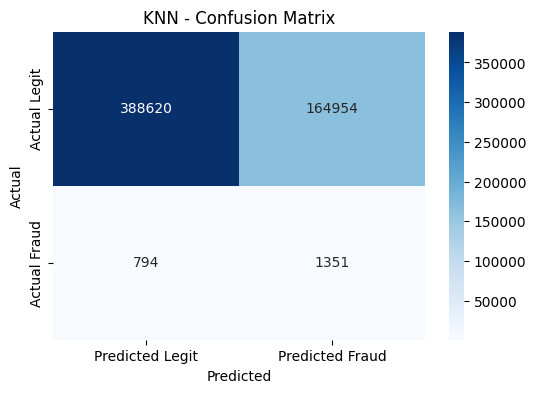

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# undersample the train data
# Separate fraud and non-fraud rows
fraud = train_cleaned[train_cleaned['is_fraud'] == 1]
legit = train_cleaned[train_cleaned['is_fraud'] == 0].sample(len(fraud), random_state=42)

# Combine to form a balanced training dataset
balanced_train = pd.concat([fraud, legit]).sample(frac=1, random_state=42)

print("Original training shape:", train_cleaned.shape)
print("Balanced training shape:", balanced_train.shape)

# split features and targets
X_train = balanced_train.drop('is_fraud', axis=1)
y_train = balanced_train['is_fraud']

X_test  = test_cleaned.drop('is_fraud', axis=1)
y_test  = test_cleaned['is_fraud']

# knn training
knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print("KNN Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Legit', 'Predicted Fraud'],
            yticklabels=['Actual Legit', 'Actual Fraud'])
plt.title("KNN - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Logistic Regression

Logistic Regression Accuracy: 0.9478099543114415

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    553574
           1       0.05      0.75      0.10      2145

    accuracy                           0.95    555719
   macro avg       0.53      0.85      0.54    555719
weighted avg       1.00      0.95      0.97    555719



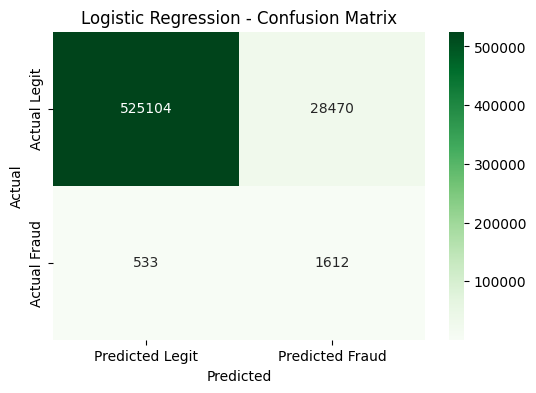

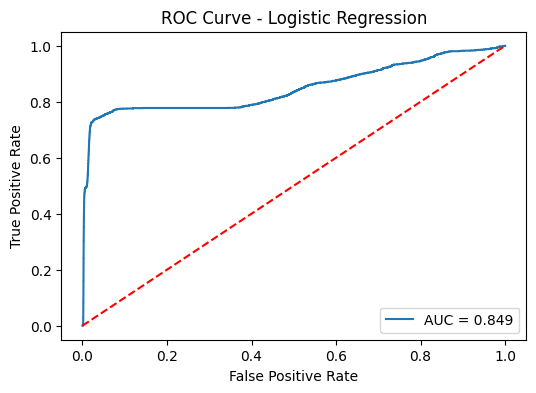

AUC Score: 0.8488523278816897


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#undersampling
fraud = train_cleaned[train_cleaned['is_fraud'] == 1]
legit = train_cleaned[train_cleaned['is_fraud'] == 0].sample(len(fraud), random_state=42)

balanced_train = pd.concat([fraud, legit]).sample(frac=1, random_state=42)

X_train = balanced_train.drop('is_fraud', axis=1)
y_train = balanced_train['is_fraud']

X_test  = test_cleaned.drop('is_fraud', axis=1)
y_test  = test_cleaned['is_fraud']

#Logistic Regression Model
log_reg = LogisticRegression(max_iter=5000, class_weight='balanced')
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted Legit', 'Predicted Fraud'],
            yticklabels=['Actual Legit', 'Actual Fraud'])
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.show()

print("AUC Score:", roc_auc)


Merchant Risk Clustering KMeans

   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F  43039 Riley Greens Suite 393  ...  48

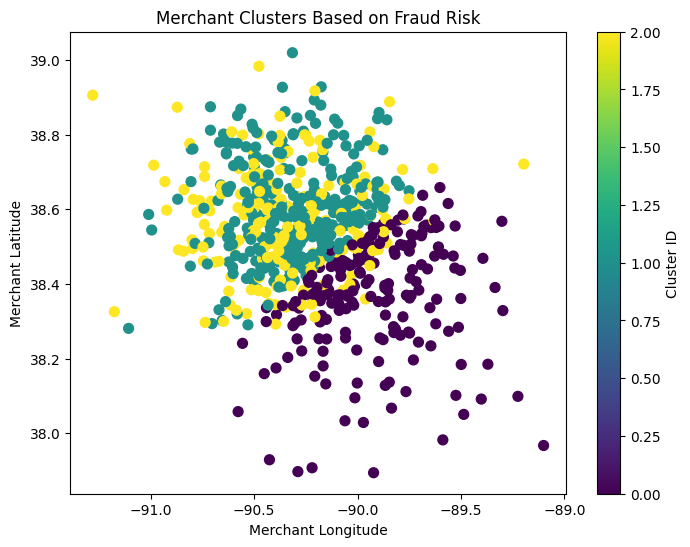


Average Fraud Rate per Cluster:
cluster
0    0.002886
1    0.002331
2    0.011476
Name: fraud_rate, dtype: float64

Top 10 High-Risk Merchants:
                                       merchant  avg_transaction_amt  \
337                           fraud_Kozey-Boehm            90.632132   
245           fraud_Herman, Treutel and Dickens            85.092497   
616                            fraud_Terry-Huel            93.995538   
304                       fraud_Kerluke-Abshire            93.090015   
443         fraud_Mosciski, Ziemann and Farrell            87.678079   
555         fraud_Schmeler, Bashirian and Price            94.033949   
346                             fraud_Kuhic LLC            90.178526   
282                              fraud_Jast Ltd            86.834849   
372        fraud_Langworth, Boehm and Gulgowski            84.483539   
528  fraud_Romaguera, Cruickshank and Greenholt            87.722819   

     fraud_rate  cluster  
337    0.021755        2  
245    0

In [ ]:
import pandas as pd

train = pd.read_csv("/content/fraudTrain.csv")
test = pd.read_csv("/content/fraudTest.csv")

df = pd.concat([train, test], ignore_index=True)

print(df.head())
print(df.columns)

merchant_stats = df.groupby("merchant").agg({
    "amt": "mean",
    "is_fraud": "mean",
    "merch_lat": "mean",
    "merch_long": "mean"
}).reset_index()

merchant_stats.rename(columns={
    "amt": "avg_transaction_amt",
    "is_fraud": "fraud_rate"
}, inplace=True)

from sklearn.preprocessing import StandardScaler

features = ["avg_transaction_amt", "fraud_rate", "merch_lat", "merch_long"]

scaler = StandardScaler()
scaled = scaler.fit_transform(merchant_stats[features])

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
merchant_stats["cluster"] = kmeans.fit_predict(scaled)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(
    merchant_stats["merch_long"],
    merchant_stats["merch_lat"],
    c=merchant_stats["cluster"],
    cmap="viridis",
    s=50
)
plt.xlabel("Merchant Longitude")
plt.ylabel("Merchant Latitude")
plt.title("Merchant Clusters Based on Fraud Risk")
plt.colorbar(label="Cluster ID")
plt.show()

print("\nAverage Fraud Rate per Cluster:")
print( merchant_stats.groupby("cluster")["fraud_rate"].mean() )

top_10_risky = merchant_stats.sort_values("fraud_rate", ascending=False).head(10)

print("\nTop 10 High-Risk Merchants:")
print(top_10_risky[["merchant", "avg_transaction_amt", "fraud_rate", "cluster"]])


Add clusters back to Train + Test data

In [ ]:
#merge cluster information into TRAIN
train_with_cluster = train.merge(
    merchant_stats[['merchant', 'cluster']],
    on='merchant',
    how='left'
)

print(train_with_cluster[['merchant', 'cluster']].head())
print("Missing cluster values:", train_with_cluster['cluster'].isna().sum())

train_with_cluster['cluster'] = train_with_cluster['cluster'].fillna(-1)

#merge cluster information into TEST
test_with_cluster = test.merge(
    merchant_stats[['merchant', 'cluster']],
    on='merchant',
    how='left'
)

print(test_with_cluster[['merchant', 'cluster']].head())
print("Missing cluster values:", test_with_cluster['cluster'].isna().sum())

test_with_cluster['cluster'] = test_with_cluster['cluster'].fillna(-1)

train_with_cluster['cluster'].value_counts()

                             merchant  cluster
0          fraud_Rippin, Kub and Mann        2
1     fraud_Heller, Gutmann and Zieme        2
2                fraud_Lind-Buckridge        1
3  fraud_Kutch, Hermiston and Farrell        1
4                 fraud_Keeling-Crist        0
Missing cluster values: 0
                               merchant  cluster
0                 fraud_Kirlin and Sons        1
1                  fraud_Sporer-Keebler        1
2  fraud_Swaniawski, Nitzsche and Welch        1
3                     fraud_Haley Group        0
4                 fraud_Johnston-Casper        0
Missing cluster values: 0


,count
cluster,
1,624198
2,347063
0,325414


KNN vs Logistic Regression


KNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    257834
           1       0.97      1.00      0.98    257834

    accuracy                           0.98    515668
   macro avg       0.98      0.98      0.98    515668
weighted avg       0.98      0.98      0.98    515668


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87    257834
           1       0.94      0.76      0.84    257834

    accuracy                           0.86    515668
   macro avg       0.87      0.86      0.85    515668
weighted avg       0.87      0.86      0.85    515668



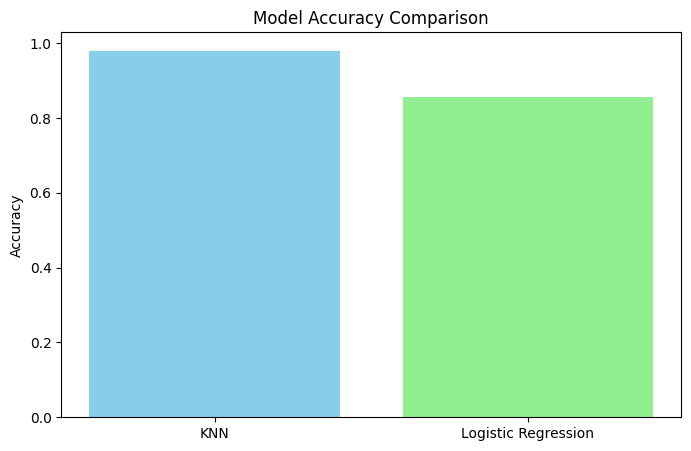

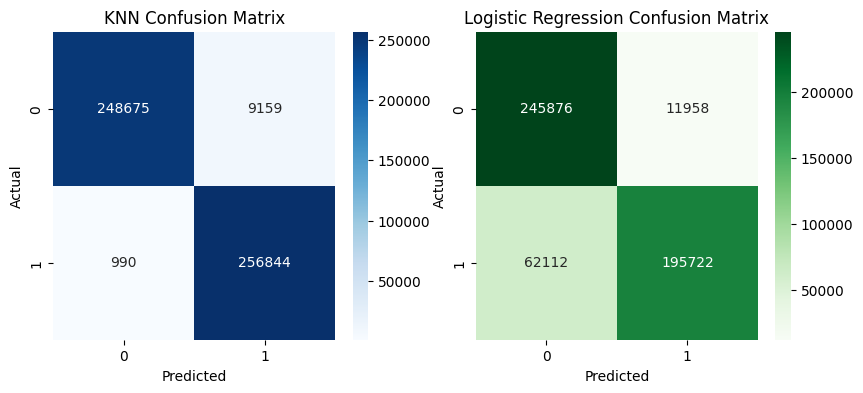

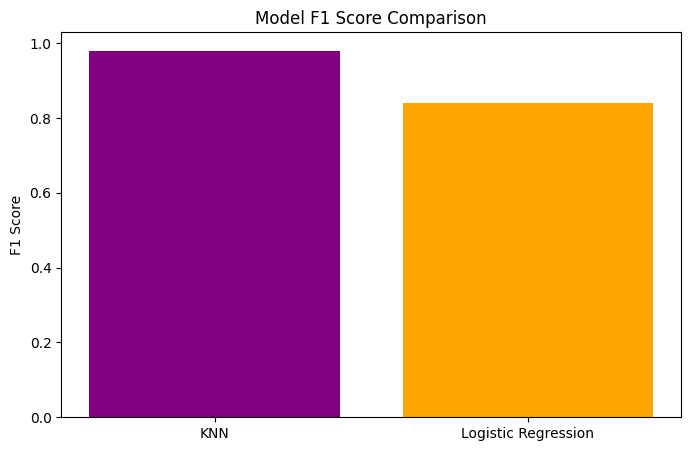

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

X = train_with_cluster[['amt', 'lat', 'long', 'cluster']]
y = train_with_cluster['is_fraud']

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

models = ["KNN", "Logistic Regression"]
accuracies = [
    accuracy_score(y_test, knn_pred),
    accuracy_score(y_test, lr_pred)
]

precisions = [
    precision_score(y_test, knn_pred),
    precision_score(y_test, lr_pred)
]

recalls = [
    recall_score(y_test, knn_pred),
    recall_score(y_test, lr_pred)
]

f1_scores = [
    f1_score(y_test, knn_pred),
    f1_score(y_test, lr_pred)
]

print("\nKNN Classification Report:")
print(classification_report(y_test, knn_pred))

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, lr_pred))

plt.figure(figsize=(8,5))
plt.bar(models, accuracies, color=['skyblue','lightgreen'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, knn_pred), annot=True, fmt='d', cmap='Blues')
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, lr_pred), annot=True, fmt='d', cmap='Greens')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

plt.figure(figsize=(8,5))
plt.bar(models, f1_scores, color=['purple','orange'])
plt.title("Model F1 Score Comparison")
plt.ylabel("F1 Score")
plt.show()


Merchant to ID mapping

In [ ]:
from sklearn.preprocessing import LabelEncoder

train_cleaned = train.copy()
test_cleaned = test.copy()

#merchant_id using LabelEncoder
le_merchant = LabelEncoder()
train_cleaned['merchant_id'] = le_merchant.fit_transform(train_cleaned['merchant'])
test_cleaned['merchant_id'] = le_merchant.transform(test_cleaned['merchant'])

merchant_to_id = dict(zip(train_cleaned['merchant'], train_cleaned['merchant_id']))

#id to name mapping
id_to_merchant = dict(zip(train_cleaned['merchant_id'], train_cleaned['merchant']))

print("Sample merchant → merchant_id mapping:")
list(merchant_to_id.items())[:10]


Sample merchant → merchant_id mapping:


[('fraud_Rippin, Kub and Mann', 514),
 ('fraud_Heller, Gutmann and Zieme', 241),
 ('fraud_Lind-Buckridge', 390),
 ('fraud_Kutch, Hermiston and Farrell', 360),
 ('fraud_Keeling-Crist', 297),
 ('fraud_Stroman, Hudson and Erdman', 607),
 ('fraud_Rowe-Vandervort', 534),
 ('fraud_Corwin-Collins', 107),
 ('fraud_Herzog Ltd', 250),
 ('fraud_Schoen, Kuphal and Nitzsche', 563)]

Model for UI

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import datetime
import gradio as gr

train = pd.read_csv('/content/fraudTrain.csv')
test = pd.read_csv('/content/fraudTest.csv')

#create merchant id by encoding their names
le_merchant = LabelEncoder()
all_merchants = pd.concat([train['merchant'], test['merchant']], ignore_index=True)
le_merchant.fit(all_merchants)
train['merchant_id'] = le_merchant.transform(train['merchant'])
test['merchant_id'] = le_merchant.transform(test['merchant'])

#extract date&time features
train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'])
test['trans_date_trans_time'] = pd.to_datetime(test['trans_date_trans_time'])

train['transaction_hour'] = train['trans_date_trans_time'].dt.hour
test['transaction_hour'] = test['trans_date_trans_time'].dt.hour

train['transaction_day'] = train['trans_date_trans_time'].dt.dayofweek
test['transaction_day'] = test['trans_date_trans_time'].dt.dayofweek

#unix_time is causing data leakage
for df in (train, test):
    if 'unix_time' in df.columns:
        df.drop(columns=['unix_time'], inplace=True)

#merchant level kmeans
merchant_stats = train.groupby('merchant').agg({
    'amt': 'mean',
    'is_fraud': 'mean',
    'merch_lat': 'mean',
    'merch_long': 'mean'
}).reset_index().rename(columns={'amt':'avg_transaction_amt', 'is_fraud':'fraud_rate'})

# scale merchant features and cluster
scaler_ms = StandardScaler()
ms_features = ['avg_transaction_amt', 'fraud_rate', 'merch_lat', 'merch_long']
merchant_scaled = scaler_ms.fit_transform(merchant_stats[ms_features])

kmeans = KMeans(n_clusters=3, random_state=42)
merchant_stats['cluster'] = kmeans.fit_predict(merchant_scaled)

merchant_stats['merchant_id'] = le_merchant.transform(merchant_stats['merchant'])

train_with_cluster = train.merge(
    merchant_stats[['merchant', 'merchant_id', 'avg_transaction_amt', 'fraud_rate', 'cluster']],
    on='merchant',
    how='left'
)
test_with_cluster = test.merge(
    merchant_stats[['merchant', 'merchant_id', 'avg_transaction_amt', 'fraud_rate', 'cluster']],
    on='merchant',
    how='left'
)

# Fill missing merchant-level stats (rare) with sensible defaults
for df in (train_with_cluster, test_with_cluster):
    df['cluster'] = df['cluster'].fillna(-1).astype(int)
    df['avg_transaction_amt'] = df['avg_transaction_amt'].fillna(0.0)
    df['fraud_rate'] = df['fraud_rate'].fillna(0.0)
    if 'merchant_id_y' in df.columns:
        df['merchant_id'] = df['merchant_id_x'].fillna(df['merchant_id_y']).astype(int)
        df.drop(columns=[c for c in df.columns if c.endswith('_x') or c.endswith('_y')], inplace=True)

features = [
    'amt',
    'merchant_id',
    'merch_lat',
    'merch_long',
    'cluster',
    'avg_transaction_amt',
    'fraud_rate',
    'transaction_hour',
    'transaction_day'
]

for f in features:
    if f not in train_with_cluster.columns:
        raise KeyError(f"Required column missing in training data: {f}")

X_all = train_with_cluster[features].copy()
y_all = train_with_cluster['is_fraud'].astype(int)

# split scale SMOTE
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled = scaler.transform(X_val_raw)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

#train knn
knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
knn.fit(X_train_res, y_train_res)

# Evaluate on validation set
y_val_pred = knn.predict(X_val_scaled)
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
print("Classification report (validation):\n", classification_report(y_val, y_val_pred))
print("Confusion matrix (validation):\n", confusion_matrix(y_val, y_val_pred))

#UI Mapping
merchant_name_to_id = dict(zip(train_with_cluster['merchant'], train_with_cluster['merchant_id']))
merchant_name_to_lat = dict(zip(train_with_cluster['merchant'], train_with_cluster['merch_lat']))
merchant_name_to_long = dict(zip(train_with_cluster['merchant'], train_with_cluster['merch_long']))
merchant_name_to_cluster = dict(zip(train_with_cluster['merchant'], train_with_cluster['cluster']))
merchant_name_to_avgamt = dict(zip(train_with_cluster['merchant'], train_with_cluster['avg_transaction_amt']))
merchant_name_to_fraudrate = dict(zip(train_with_cluster['merchant'], train_with_cluster['fraud_rate']))

merchant_names = sorted(list(merchant_name_to_id.keys()))

#Gradio UI
def predict_ui(merchant_name, amount, date, time):
    try:
        if merchant_name not in merchant_name_to_id:
            return "Unknown merchant (not in training)."

        try:
            dt = datetime.datetime.strptime(date + ' ' + time, "%Y-%m-%d %H:%M")
        except Exception as e:
            return f"Invalid date/time format. Use YYYY-MM-DD and HH:MM. ({e})"

        t_hour = dt.hour
        t_day = dt.weekday()

        m_id = merchant_name_to_id[merchant_name]
        lat = merchant_name_to_lat[merchant_name]
        long = merchant_name_to_long[merchant_name]
        cluster_val = merchant_name_to_cluster.get(merchant_name, -1)
        avg_amt = merchant_name_to_avgamt.get(merchant_name, 0.0)
        fraud_rate = merchant_name_to_fraudrate.get(merchant_name, 0.0)

        row = np.array([[float(amount), int(m_id), float(lat), float(long), int(cluster_val),
                         float(avg_amt), float(fraud_rate), int(t_hour), int(t_day)]])

        row_scaled = scaler.transform(row)

        prob = knn.predict_proba(row_scaled)[0][1]
        pred = knn.predict(row_scaled)[0]
        label = "FRAUD" if int(pred) == 1 else "LEGIT"

        if cluster_val == 2:
            risk = "HIGH RISK MERCHANT"
        elif cluster_val == 1:
            risk = "MEDIUM RISK MERCHANT"
        elif cluster_val == 0:
            risk = "LOW RISK MERCHANT"
        else:
            risk = "UNKNOWN"

        return (f"Transaction Date: {date}\n"
                f"Transaction Time: {time}\n"
                f"Merchant: {merchant_name}\n"
                f"Amount: {amount}\n\n"
                f"Prediction: {label}\n"
                f"Merchant Risk: {risk}\n"
                f"Fraud probability: {prob*100:.2f}%\n"
                f"Cluster: {cluster_val}")
    except Exception as e:
        return f"Error: {str(e)}"

ui = gr.Interface(
    fn=predict_ui,
    inputs=[
        gr.Dropdown(merchant_names, label="Merchant"),
        gr.Number(label="Transaction Amount"),
        gr.Textbox(label="Transaction Date (YYYY-MM-DD)"),
        gr.Textbox(label="Transaction Time (HH:MM)")
    ],
    outputs=gr.Textbox(label="Prediction", lines=12),
    title="Credit Card Fraud Detection (KNN + Merchant Clusters)",
    description="Select merchant and enter transaction date/time + amount (date format YYYY-MM-DD, time HH:MM)."
)

ui.launch()


Validation accuracy: 0.980557965565774
Classification report (validation):
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    257834
           1       0.20      0.76      0.31      1501

    accuracy                           0.98    259335
   macro avg       0.60      0.87      0.65    259335
weighted avg       0.99      0.98      0.99    259335

Confusion matrix (validation):
 [[253145   4689]
 [   353   1148]]
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://808a52a8c71c236d4b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spa